# Classification. Linear models and KNN

In [7]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [9]:
from sklearn.exceptions import NotFittedError

In [10]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-7, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.get_loss_history=[]
        self.convergence=0
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""   
        pol=X@weights
        return 1/(1+np.exp(-pol)) 
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        
        return  np.array([np.log(1+np.exp(-weights@x[zal]*y[zal])) for zal in range(x.shape[0])]).mean()+sum(np.square(np.abs(weights)))/2/self.C
        #return (np.log(1+np.exp(-(self.weights_@x.T@y))))/x.shape[0]+1/(self.C*2)*np.square(sum(np.abs(self.weights_)))
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
          
        for i in range(self.max_iter):
            self.get_loss_history.append(self.get_loss(X_ext, self.weights_, y))
            for zal in range(X_ext.shape[0]):
                bum=y[zal]*X_ext[zal]*(1-1/(1+np.exp(-self.weights_@X_ext[zal]*y[zal])))
                if(zal==0):
                    summa=bum
                else:
                    summa=summa+bum
            summa/X_ext.shape[0]+1/self.C*self.weights_
            delta = -summa/X_ext.shape[0]+1/self.C*self.weights_
            
            #delta = -y@X_ext*(1-1/(1+np.exp(-self.weights_@X_ext.T@y)))/X_ext.shape[0]+1/self.C*self.weights_
            self.weights_ -= self.eta * delta
            prov=np.sqrt(sum(np.square(np.abs(self.eta * delta))))
            self.convergence=self.convergence+1
            if prov<self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        uo=self.predict_proba(X)
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        pred_value = np.where(uo >= .5,1,-1)
        return np.squeeze(pred_value)

In [11]:
from sklearn import datasets
from sklearn import metrics

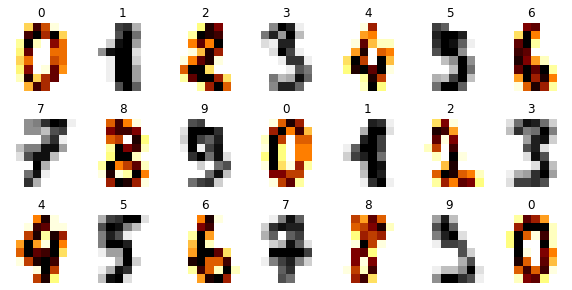

In [12]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
#X_train=StandardScaler().fit_transform(X_train)
#X_test=StandardScaler().fit_transform(X_test)
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [13]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [14]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [15]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [16]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [17]:
lr_clf.fit(X_train, y_train)

In [18]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [19]:
model = CustomLogisticRegression()

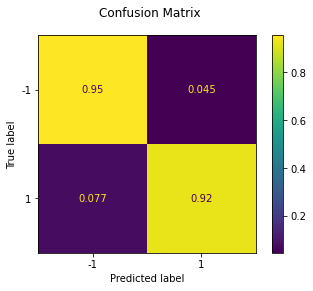

In [20]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [21]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [22]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

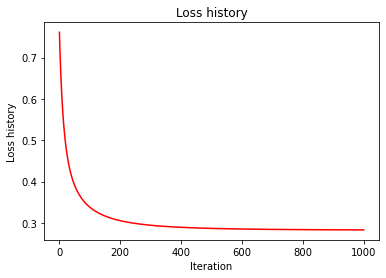

In [23]:
## your code

y = np.array(model.get_loss_history)
x = np.arange(1, y.shape[0]+1)
# plotting
plt.title("Loss history")
plt.xlabel("Iteration")
plt.ylabel("Loss history")
plt.plot(x, y, color ="red")
plt.show()

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

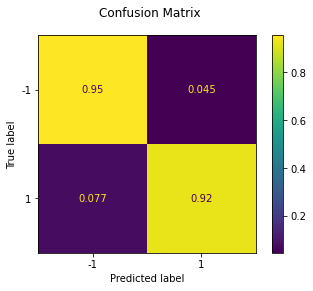

Eta: 0.001
Metrics: 0.9109255393180237 0.9388888888888889


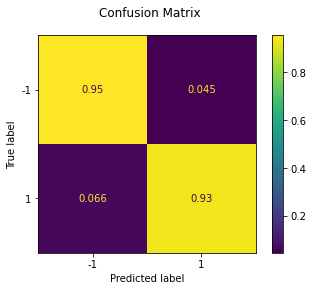

Eta: 0.002
Metrics: 0.9144050104384134 0.9444444444444444


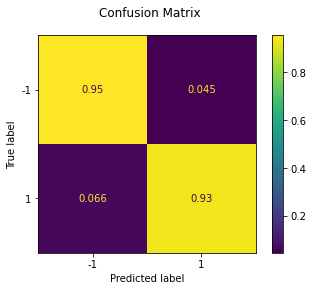

Eta: 0.003
Metrics: 0.9151009046624913 0.9444444444444444


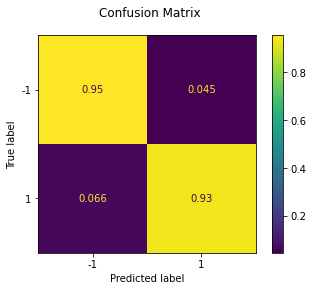

Eta: 0.004
Metrics: 0.9157967988865693 0.9444444444444444


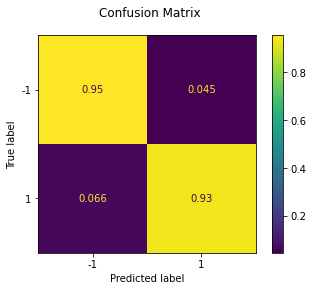

Eta: 0.005
Metrics: 0.9157967988865693 0.9444444444444444


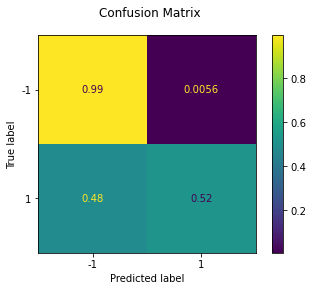

Eta: 0.01
Metrics: 0.7731384829505915 0.7527777777777778


C:\Users\CD86~1\AppData\Local\Temp/ipykernel_22320/2715200669.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(all_lost)


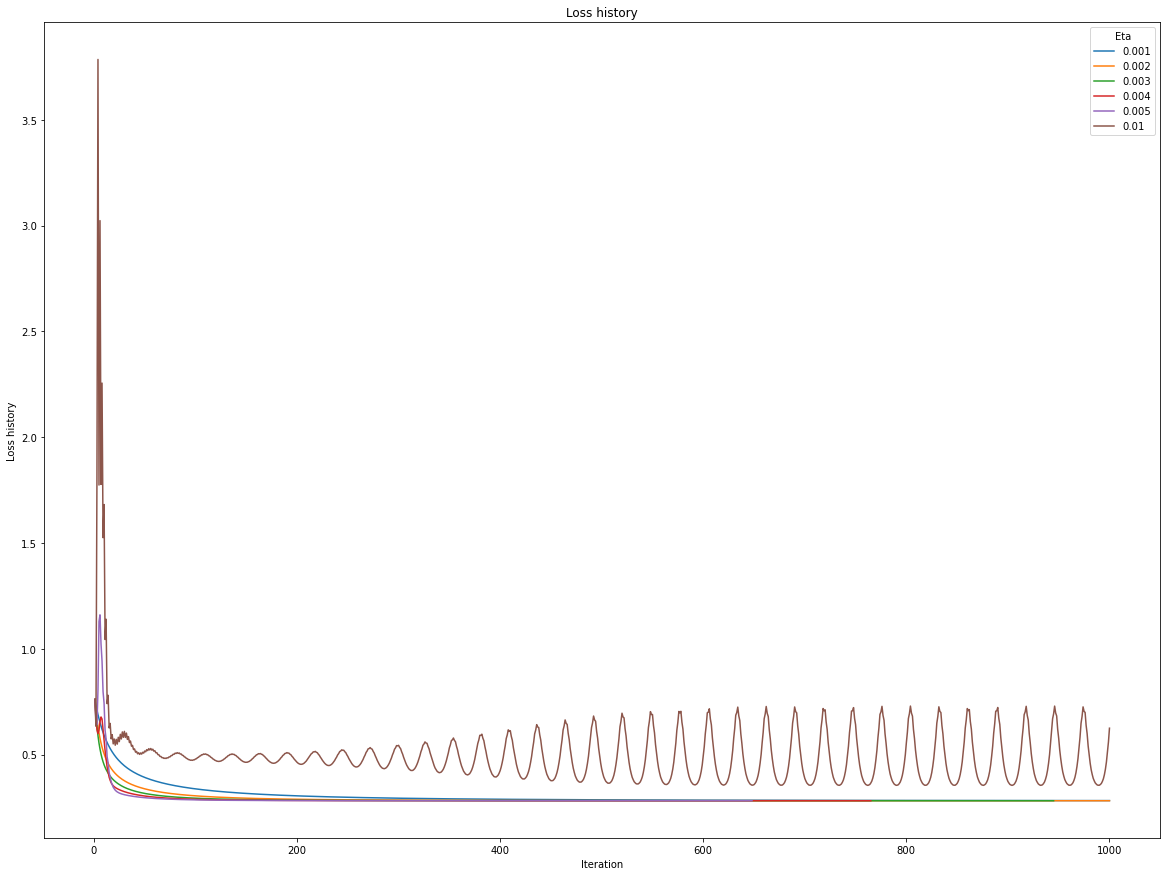

In [24]:
## your code
eta_list = [0.001, 0.002, 0.003, 0.004, 0.005,0.01]
all_lost=[]
for eta_i in eta_list:
    lr_clf = CustomLogisticRegression(eta=eta_i,max_iter=1000, tol=1e-5)
    train_acc, test_acc = fit_evaluate(lr_clf, X_train, y_train, X_test, y_test)
    print('Eta:', eta_i)
    print('Metrics:',train_acc, test_acc)
    all_lost.append(np.array(lr_clf.get_loss_history))
y = np.array(all_lost)
x = np.arange(1, y[0].shape[0]+1)
# plotting
plt.figure(figsize = (20,15))
plt.title("Loss history")
plt.xlabel("Iteration")
plt.ylabel("Loss history")
plt.plot(np.arange(1, y[0].shape[0]+1), y[0])
plt.plot(np.arange(1, y[1].shape[0]+1), y[1])
plt.plot(np.arange(1, y[2].shape[0]+1), y[2])
plt.plot(np.arange(1, y[3].shape[0]+1), y[3])
plt.plot(np.arange(1, y[4].shape[0]+1), y[4])
plt.plot(np.arange(1, y[5].shape[0]+1), y[5])
#plt.plot(np.arange(1, y[6].shape[0]+1), y[6])
plt.legend(labels=["0.001", "0.002", "0.003", "0.004", "0.005","0.01"], title = "Eta")
plt.show()



## Вывод
Как можем заметить лучшие результаты были показаны со значениями Eta: 0.005, тогда достигаются самые лучшие метрики.

Так же глядя на график лосс функции в зависмости от разных eta можем заменить, что лучщше всего функция сходится при Eta: 0.005 и хуже всего при Eta=0,1 и чем больше будет Eta тем будет больше расхождение. По итогу расхождение улучшается при увеличении Eta, но только до какого-то значения Eta.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

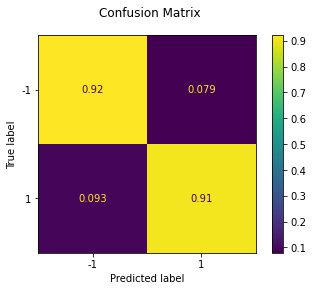

C: 0.1
Metrics: 0.8872651356993737 0.9138888888888889


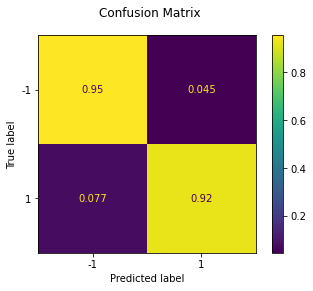

C: 1
Metrics: 0.9109255393180237 0.9388888888888889


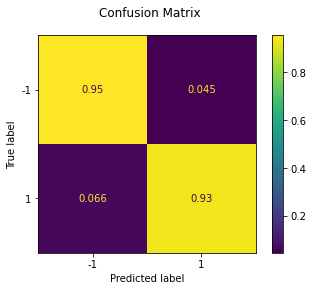

C: 5
Metrics: 0.9151009046624913 0.9444444444444444


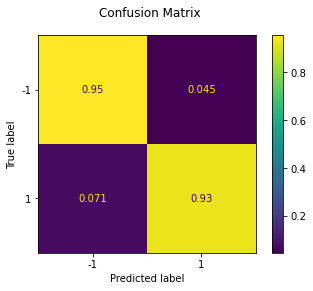

C: 10
Metrics: 0.9151009046624913 0.9416666666666667


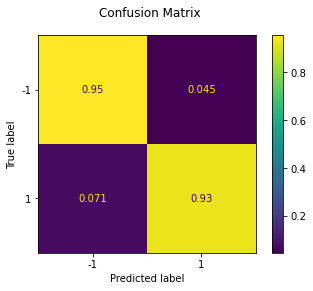

C: 15
Metrics: 0.9144050104384134 0.9416666666666667


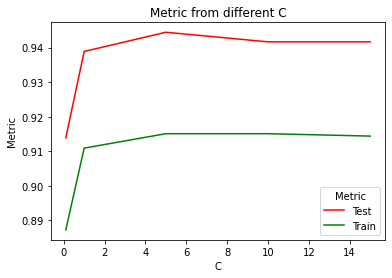

In [25]:
## your code
C_list = [0.1, 1, 5, 10, 15]
metric_history_test=[]
metric_history_train=[]
for C_i in C_list:
    lr_clf = CustomLogisticRegression(C=C_i,max_iter=1000, tol=1e-5)
    train_acc, test_acc = fit_evaluate(lr_clf, X_train, y_train, X_test, y_test)
    metric_history_test.append(test_acc)
    metric_history_train.append(train_acc)
    print('C:', C_i)
    print('Metrics:',train_acc, test_acc)
y = np.array(metric_history_test)
z = np.array(metric_history_train)
x = np.array(C_list)
# plotting
plt.title("Metric from different C")
plt.xlabel("C")
plt.ylabel("Metric")
plt.plot(x, y, color ="red")
plt.plot(x, z, color ="green")
plt.legend(labels=["Test","Train"], title = "Metric")
plt.show()

## Выводы
Как можно заметить самые лучше результаты метрик модель показывает на значении С равным 5 , остальные значения не приносят лучшего значения. При значении С=0.1 получены самые плозие результаты по метрикам.

**(0.5 points)** Compare zero initialization and random initialization. 

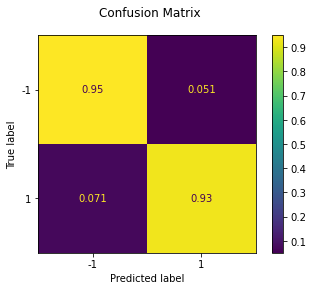

Zero init 0.9116214335421016 0.9388888888888889


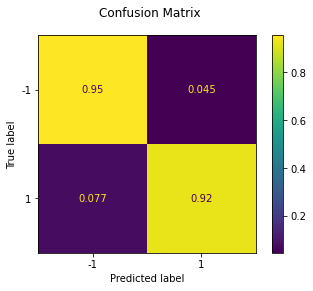

Non Zero init 0.9109255393180237 0.9388888888888889


In [26]:
## your code
lr_clf = CustomLogisticRegression(zero_init=True)
train_acc, test_acc = fit_evaluate(lr_clf, X_train, y_train, X_test, y_test)
print('Zero init',train_acc, test_acc)

lr_clf = CustomLogisticRegression()
train_acc, test_acc = fit_evaluate(lr_clf, X_train, y_train, X_test, y_test)
print('Non Zero init',train_acc, test_acc)

## Выводы
Как можем заметить модель, у которой веса были пронулированны в начале, показала более лучший результат по метрикам на тренировочных данных, а на тестовых данных результаты одинаковы, то есть можно сказать что в данном случае точности моделей почти идентичная, но немного лучше на зануленных коэффициентах.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [27]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        return (-2 * X@Y.T + np.sum(Y**2,axis=1) + np.sum(X**2,axis=1)[:, np.newaxis])**.5
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>               
        return np.array([sum(weights[np.where(y == cla)]) for cla in self.classes_]) 
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        #print(self.y)
        self.classes_ = np.unique(y)
        #print( self.classes_)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            #print(self.points)
            P = self.get_pairwise_distances(X, self.points)
            #print(P.shape)
            #print(self.y.shape)
            weights_of_points = np.ones(P.shape)
            #print(weights_of_points.shape)
            
            #print(self.get_class_weights(self.y, self.weights))
            if self.weights == 'distance':
                weights_of_points =np.zeros(P.shape) 
                
                loop=np.array( [uuu.argsort()[:self.n_neighbors]  for uuu in P])
                #print(loop)
                for uuuu in range(len(weights_of_points)):
                    for ppoo in loop[uuuu]:
                        weights_of_points[uuuu][ppoo]=1/(P[uuuu][ppoo]+self.eps)
            if self.weights == 'uniform':    
                weights_of_points =np.zeros(P.shape) 
                
                loop=np.array( [uuu.argsort()[:self.n_neighbors]  for uuu in P])
                #print(loop)
                for uuuu in range(len(weights_of_points)):
                    for ppoo in loop[uuuu]:
                        weights_of_points[uuuu][ppoo]=1
            #print(weights_of_points)    
            #print(weights_of_points.shape)
            
            lol=np.array([self.get_class_weights(self.y, bu)/sum(self.get_class_weights(self.y, bu)) for bu in weights_of_points])
            #print(lol.sum())
            #print(lol[0])
            #bum=np.array([ for lo in lol])
            #print(lol.shape)
            #weights_of_points*self.y
            # <your code>
            return lol
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        self.predict_proba(X)
        return np.array([np.argmax(pre) for pre in self.predict_proba(X)])
        #return np.argmax(self.predict_proba(X))

In [28]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [29]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [30]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

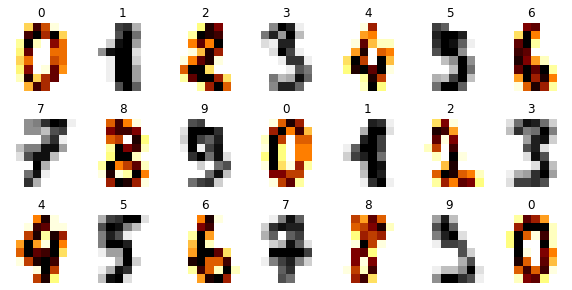

In [31]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [32]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [33]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

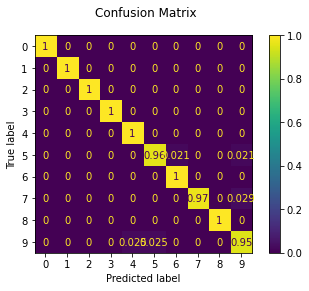

In [34]:
train_acc, test_acc = fit_evaluate(knn, X_train, y_train, X_test, y_test)

In [35]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

## Выводы
Глядя на матрицу запутанности, мы замечаем, что некоторые цифры путаются, происходит небольшая ошибка на некоторых цифрах, например:
* настоящая 5 иногда предсказывается как 6 или 9
* настоящая 7 иногда предсказывается как 9
* настоящая 9 иногда предсказывается как 4 или 5

Это происходит из-за того что данные цифры очень похожи по написанию и когда у нас  есть картинка 8X8 то могут воникать подобные ошибки мз-за небольшой детализации.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

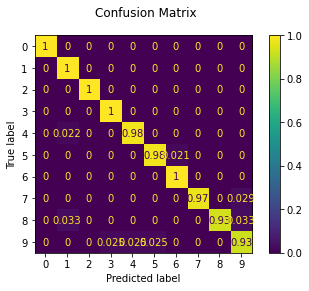

N_neighbors: 1
Metrics: 1.0 0.9777777777777777


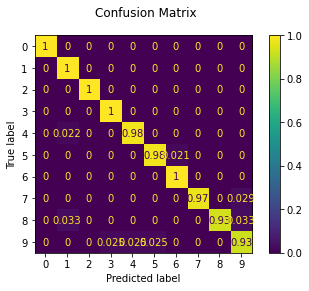

N_neighbors: 2
Metrics: 1.0 0.9777777777777777


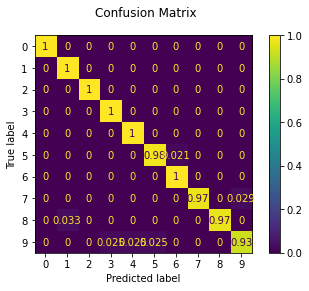

N_neighbors: 3
Metrics: 1.0 0.9833333333333333


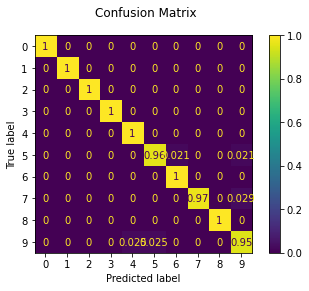

N_neighbors: 5
Metrics: 1.0 0.9861111111111112


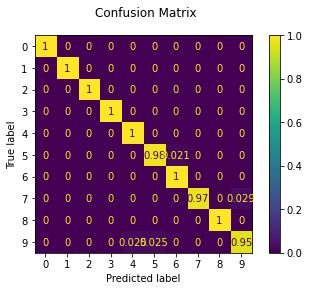

N_neighbors: 7
Metrics: 1.0 0.9888888888888889


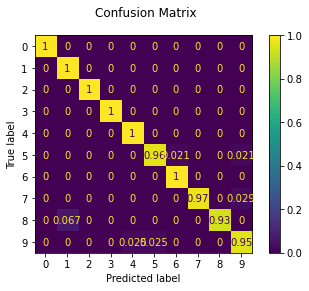

N_neighbors: 9
Metrics: 1.0 0.9805555555555555


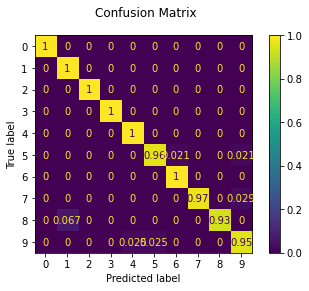

N_neighbors: 10
Metrics: 1.0 0.9805555555555555


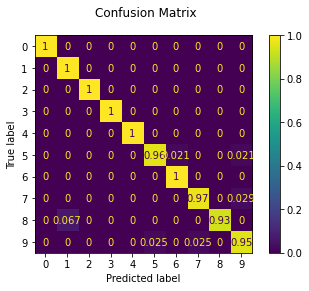

N_neighbors: 15
Metrics: 1.0 0.9805555555555555


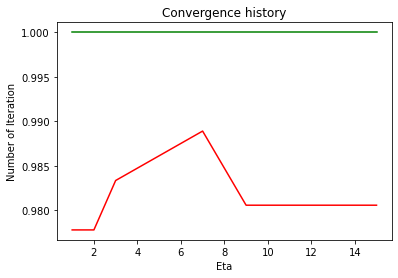

In [36]:
## your code

## your code
metric_history_test=[]
metric_history_train=[]
n_neighbors_list = [1, 2, 3, 5, 7, 9, 10, 15]
for n_neighbors in n_neighbors_list:
    lr_clf = CustomKNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
    train_acc, test_acc = fit_evaluate(lr_clf, X_train, y_train, X_test, y_test)
    metric_history_test.append(test_acc)
    metric_history_train.append(train_acc)
    print('N_neighbors:', n_neighbors)
    print('Metrics:',train_acc, test_acc)
y = np.array(metric_history_test)
z = np.array(metric_history_train)
x = np.array(n_neighbors_list)
# plotting
plt.title("Convergence history")
plt.xlabel("Eta")
plt.ylabel("Number of Iteration")
plt.plot(x, y, color ="red")
plt.plot(x, z, color ="green")
plt.show()



## Выводы
Как можем заметить самые лучшие результаты модель показывает при N ближайших соседей равных 7. 

На этих данных модель показывает улучшение при увеличении N_neighbors до значения 7, после данного значения качество падает и не изменяется.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

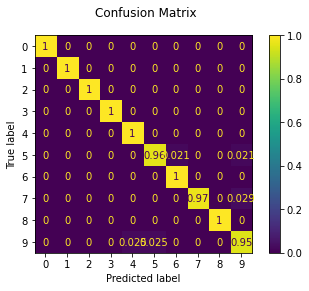

Metrics: 1.0 0.9861111111111112


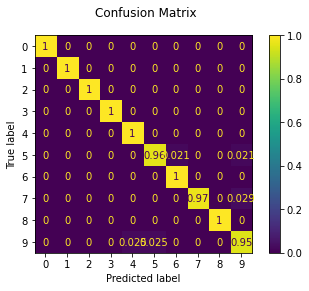

Metrics: 0.9895615866388309 0.9861111111111112


In [37]:
## your code
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('Metrics:',train_acc, test_acc)

model = CustomKNeighborsClassifier(n_neighbors=5, weights='uniform')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('Metrics:',train_acc, test_acc)

## Выводы
Как можем заметить uniform и distance одинаково хорошо работают на тестовых данных, но на тестовых данных uniform проседает немного.

В задачах в которых нам не важно настолько каждая точка ближе к другой, то есть мы не хотим выдавать важность каждой точке как более большйо вес, мы можем использвоать метод uniform, так как он выдает одинаковый вес для всех точек для ближайших k соседей, а когда нам необходимо давать важность весу каждой точке, то тогда лучше использовать distance.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

### Another distance measurement function

Существуют разнычные функции измерения расстояний, например такие как:
    
* Manhattan Distance. Высчитывается как сумма модулей расстояния между точками.
* Cosine Distance. Эта метрика расстояния используется в основном для вычисления сходства между двумя векторами. Оно измеряется косинусом угла между двумя векторами и определяет, указывают ли два вектора в одном и том же направлении.
* Jaccard Distance. Это метод сравнения, аналогичный косинусному подобию, поскольку оба метода сравнивают один тип атрибута, распределенного среди всех данных. Подход Жаккара рассматривает два набора данных и находит инцидент, в котором оба значения равны 1. Таким образом, результирующее значение отражает, сколько совпадений 1 к 1 происходит по сравнению с общим количеством точек данных


##### Но в данном функция расстояния,которая могла бы улучшить качество классификации для этой задачи, является Manhattan Distance так как она в отличии от Эвклидова расстояния лучше работает на больших данных, коими являются наши данные.

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

### Suggest different task and distance function that you think would be suitable for it.

Одной из задач KNN может быть задача Рекомендательных систем для онлайн кинотеатра, например Netflix. На основе понравившихся пользователю фильмов мы можем предложить ему похожие фильмы использовав модель KNN. У каждого фильма будут отметки 1 или 0 на жанрах к которому он относится, при этом жанров может быть не один (например: триллер, детектив, боевик).

Для этой задачи отлично подойжет Эвклидово расстояние, но так же хорошо будет работать Жакардово расстояние.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [626]:
PATH = "./data/"

In [627]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [628]:
data.head(50)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
5,0,2,"Sassano, Jonathan",male,35.00,0,0,13363,6.71,NaN,S
6,0,3,"Conway, Jose",male,7.00,0,0,A/5,9.77,NaN,S
7,1,3,"Werner, Linda",female,6.00,1,2,434426,31.50,NaN,S
8,0,1,"Wardlaw, Michael",male,27.00,2,1,474849,73.02,A7253,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

Проверим количество мужчин и женщин

In [629]:
## your code
data.groupby('Sex').size()

Sex
female    43886
male      56114
dtype: int64

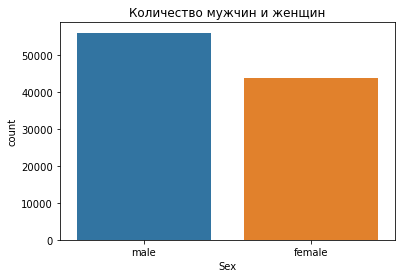

In [630]:
plt.figure(figsize=(6,4))
sns.countplot(x=data['Sex'])
plt.title("Количество мужчин и женщин")
plt.show()

Как можем видеть в этих данных мужчим больше чем женщин. Количество мужчин равно 56114, а женщин 43886.

Проверим количество выживших и погибших:

In [631]:
data.groupby('Survived').size()

Survived
0    57226
1    42774
dtype: int64

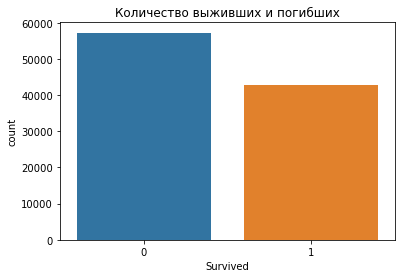

In [632]:
plt.figure(figsize=(6,4))
sns.countplot(x=data['Survived'])
plt.title("Количество выживших и погибших")
plt.show()

Как можем видеть в этих данных погибших больше чем выживших. Количество погибших равно 57226, а выживших 42774.

Проверим есть ли зависимость между полом пассажира и выжил ли он или нет:

In [633]:
data.groupby(['Survived','Sex']).size()

Survived  Sex   
0         female    12660
          male      44566
1         female    31226
          male      11548
dtype: int64

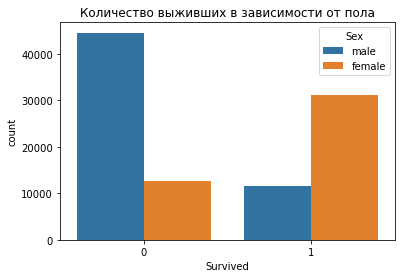

In [634]:
plt.figure(figsize=(6,4))
sns.countplot(x=data['Survived'], hue=data['Sex'])
plt.title("Количество выживших в зависимости от пола")
plt.show()

Видим что среди погибших было больше мужчин, а среди выживших наоборот женщин было больше, то есть существует зависимость выживемости от пола.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

Построим распределение пассажиров по возрасту

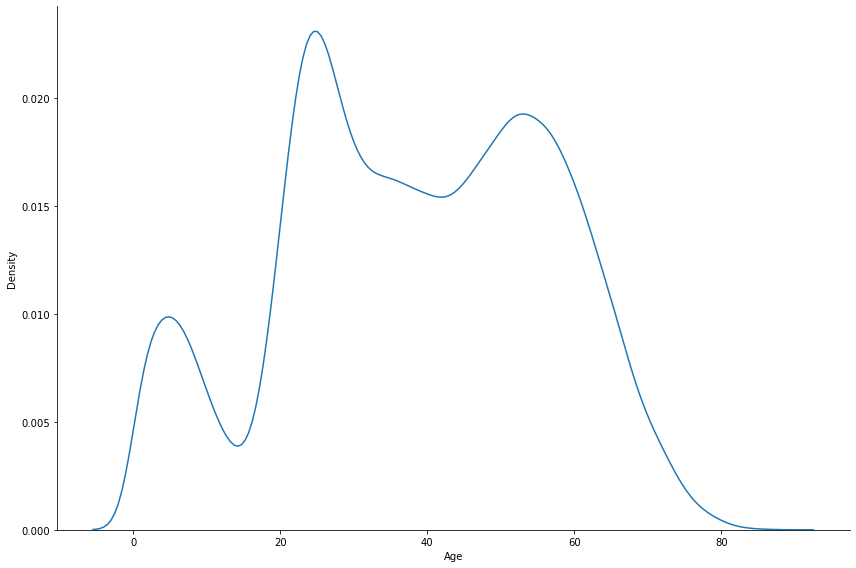

In [635]:
sns.displot(data=data, x="Age", kind="kde",height=8,aspect=1.5)

Посмотрим на среднее значение возраста и медиану возраста в зависимости от переменной Survived

In [636]:
print('For all passangers |','Mean:',data['Age'].mean(),'| Median:',data['Age'].median())
print('Not Survived |','Mean:',data[data['Survived']==0]['Age'].mean(),'| Median:',data[data['Survived']==0]['Age'].median())
print('Survived |','Mean:',data[data['Survived']==1]['Age'].mean(),'| Median:',data[data['Survived']==1]['Age'].median())



For all passangers | Mean: 38.35547214294576 | Median: 39.0
Not Survived | Mean: 36.708694881533724 | Median: 36.0
Survived | Mean: 40.55379931430776 | Median: 43.0


Так же построим график распределения возраста в зависимости от выжил ли пассажир:

<Figure size 1296x576 with 0 Axes>

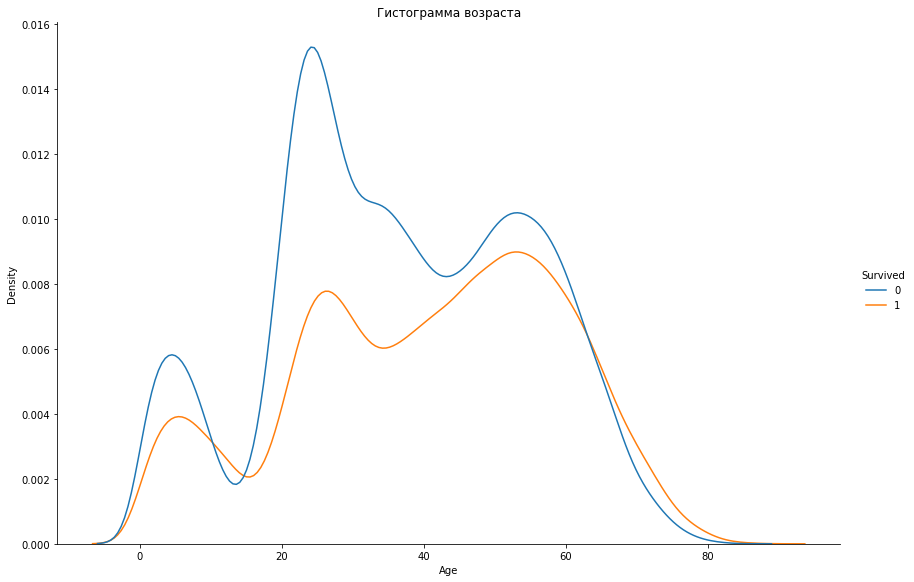

In [637]:
## your code
plt.figure(figsize=(18,8))
sns.displot(data=data, x="Age", hue="Survived", kind="kde",height=8,aspect=1.5)
plt.title("Гистограмма возраста")
plt.show()

## Выводы
Как можем видеть:
* среднее значение возраста и медиана меньше чем у выживших пассажиров.
* среднее значение возраста и медиана меньше чем медиана и среднее значение по всем пассажирам.
* в свою очередь медиана и среднее значение возраста у выживших пассажирова больше чем медиана и серднее у всех пассажиров.
* это можно объяснить тем что стариков спасали чаще чем молодых людей, это можно заметить по графику так как есть отрезок от 65 лет, где доля выживших пассажиров постоянно больше чем доля погибших пассажиров.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

Исследуем переменную "passenger class":

In [638]:
data.groupby('Pclass').size()

Pclass
1    30315
2    28679
3    41006
dtype: int64

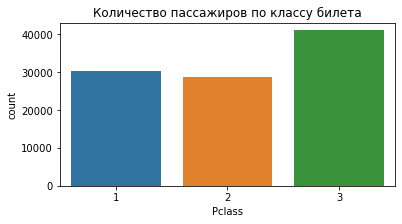

In [639]:
plt.figure(figsize=(6,3))
sns.countplot(x=data['Pclass'])
plt.title("Количество пассажиров по классу билета")
plt.show()

Видно, что больше всего пассажиров ехало в 3 Классе, а меньше всего во 2 Классе.

Исследуем существует ли зависимость Класса билета от выживаемости.

In [640]:
data.groupby(['Pclass','Survived']).size()

Pclass  Survived
1       0           12739
        1           17576
2       0           13622
        1           15057
3       0           30865
        1           10141
dtype: int64

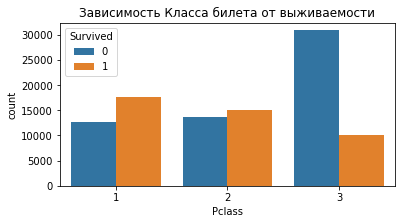

In [641]:
plt.figure(figsize=(6,3))
sns.countplot(x=data['Pclass'],hue=data['Survived'])
plt.title("Зависимость Класса билета от выживаемости")
plt.show()

Можем наблюдать отличную закономерность, что в первом и втором классе выжило больше человек чем погибло, а вот в третьем классе совсем наоброт.

Исследуем переменную "embarked":

In [642]:
data.groupby('Embarked').size()

Embarked
C    22187
Q     5424
S    72139
dtype: int64

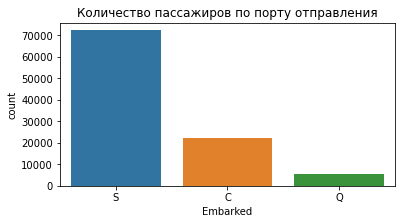

In [643]:
plt.figure(figsize=(6,3))
sns.countplot(x=data['Embarked'])
plt.title("Количество пассажиров по порту отправления")
plt.show()

Больше всего село человек в Сангеумптоне.

Исследуем существует ли зависимость выживаемости от порта отправления.

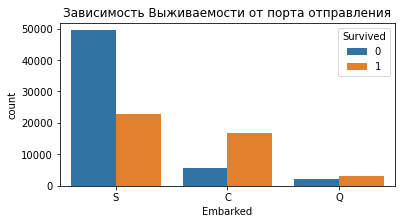

In [644]:
plt.figure(figsize=(6,3))
sns.countplot(x=data['Embarked'],hue=data['Survived'])
plt.title("Зависимость Выживаемости от порта отправления")
plt.show()

Наглядно видно, что если человек сел Саунгептоне, то вероятнее он погиб чем выжил в отличии от других портов отправления.

А проверим зависимость порта отправления и Класса билета.

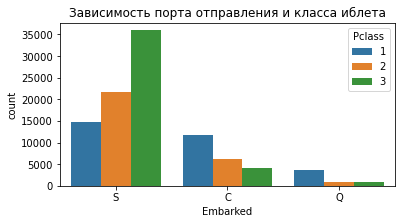

In [645]:
plt.figure(figsize=(6,3))
sns.countplot(x=data['Embarked'],hue=data['Pclass'])
plt.title("Зависимость порта отправления и класса иблета")
plt.show()

Теперь все понятно, потому что в Саунгемптоне село больше бедных людей, которые купили билет 3 класса, а в остальных городах наоброт больше богатых, поэтому наблюдается подобная зависимость, где больше людей погибших было из тех кто сел в Саунгемптоне, так как они вероятнее всего купили более дешевый билет.

## Выводы
Можно сделать подобные выводы: 
* больше всего пассажиров ехало в 3 Классе, а меньше всего во 2 Классе
* в первом и втором классе выжило больше человек чем погибло, а вот в третьем классе совсем наоброт
* больше всего село человек в Сангеумптоне
* если человек сел Саунгептоне, то вероятнее он погиб чем выжил в отличии от других портов отправления
* в Саунгемптоне село больше бедных людей, которые купили билет 3 класса, а в остальных городах наоброт больше богатых, поэтому наблюдается подобная зависимость, где больше людей погибших было из тех кто сел в Саунгемптоне, так как они вероятнее всего купили более дешевый билет

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [646]:
## your code
print('Percentage of missing values for each feature:')
data.isnull().sum()/100000*100

Percentage of missing values for each feature:


Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
Age          3.292
SibSp        0.000
Parch        0.000
Ticket       4.623
Fare         0.134
Cabin       67.866
Embarked     0.250
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

#### Есть несколько способов как справиться с этими отсутствующими значениями:

* Можно вообще удалить строки где существуют отсутсвующие значения, но жто очень грядно, так как у нас сократиться база для тренировки, особенно когда в поле Cabin так много отсутствующих значений.
* Некоторые значения можно заменить на средние(плюсы что так мы подгоним под всю модель и заполним значениями которые средние по всей тренировочной базе, а минусы что мы не проанализировав другие переменные присвоим людям не те значения возраста например, а так де очень плохо будут влиять выбросы)
* можно заменить эти значения рандомными из всей выборки по переменной (для построения модели вносит только дополнительные проблемы)
* можно заменить на медианные (плюс в том что в отличии от среднего у нас не так сильно влияют выбросы)
* можно заменять на моду, присвоиться самое популярное значение из выборки переменной
* Можно заполнить пропущенные значения новой созданой переменной, которой нет в выборке и не относить ее ни к одному из существующих классов, а создать отдельный, анпример как в Embarked для пропущенных значений ввести порт отправления 'Неизвестен'
* замена предыдущим или следующим значением , перед или после отсутсвующего значения( минусы в том что это не информативно)

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

Заполним пропущенные данные:

In [647]:
data['Age'] = data['Age'].fillna(data['Age'].median())
data['Fare'] = data['Fare'].fillna(data['Fare'].median())
data['Embarked'] = data['Embarked'].fillna('U')
data['Cabin'] = data['Cabin'].fillna('U')
data['Ticket'] = data['Ticket'].fillna('U')
data['Cabin'] = data['Cabin'].fillna('X')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       100000 non-null  float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    100000 non-null  object 
 8   Fare      100000 non-null  float64
 9   Cabin     100000 non-null  object 
 10  Embarked  100000 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 11.2+ MB


Посмотрим еще раз на данные и выведем процент пропущеных значений:

In [648]:
## your code
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,39.00,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,39.00,0,0,27323,13.35,U,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,U,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,U,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,U,S
...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,U,S
99997,0,3,"Childress, Charles",male,37.00,0,0,U,9.95,U,S


In [649]:
print('Percentage of missing values for each feature:')
data.isnull().sum()/100000*100

Percentage of missing values for each feature:


Survived    0.0
Pclass      0.0
Name        0.0
Sex         0.0
Age         0.0
SibSp       0.0
Parch       0.0
Ticket      0.0
Fare        0.0
Cabin       0.0
Embarked    0.0
dtype: float64

Как можем видеть все пропущенные значения заполнены. Отлично.

Преобразуем некоторые категориальные переменные в числовые, а некоторые уберем из данных.

In [650]:
#Поменяем пол
data['Sex'] = np.where(data['Sex']=='male', 1, 0)


#Поменяем порт отправления
data.loc[data['Embarked']=='S', 'Embarked']= 0
data.loc[data['Embarked']=='Q', 'Embarked']= 1
data.loc[data['Embarked']=='C', 'Embarked']= 2
data.loc[data['Embarked']=='U', 'Embarked']= -1

data.loc[data['Cabin'].str[0]=='A', 'Cabin']= 1
data.loc[data['Cabin'].str[0]=='B', 'Cabin']= 2
data.loc[data['Cabin'].str[0]=='C', 'Cabin']= 3
data.loc[data['Cabin'].str[0]=='D', 'Cabin']= 4
data.loc[data['Cabin'].str[0]=='E', 'Cabin']= 5
data.loc[data['Cabin'].str[0]=='F', 'Cabin']= 6
data.loc[data['Cabin'].str[0]=='G', 'Cabin']= 7
data.loc[data['Cabin'].str[0]=='T', 'Cabin']= 1
data.loc[data['Cabin'].str[0]=='U', 'Cabin']= 8


data.loc[data['Age'].le(16), 'Age']= 0
data.loc[data['Age'].gt(16) & data['Age'].le(32), 'Age']= 1
data.loc[data['Age'].gt(32) & data['Age'].le(48), 'Age']= 2
data.loc[data['Age'].gt(48) & data['Age'].le(64), 'Age']= 3
data.loc[data['Age'].gt(64), 'Age']= 4
data['Age'].astype(int)

data.loc[data['Fare'].le(7.25), 'Fare']= 0
data.loc[data['Fare'].le(14.5) & data['Fare'].gt(7.25), 'Fare']= 1
data.loc[data['Fare'].le(31) & data['Fare'].gt(14.5), 'Fare']= 2
data.loc[data['Fare'].gt(31), 'Fare']= 4
data['Fare'].astype(int)
'''
def label_race (row):
    if row['SibSp']==0 & row['Parch']==0 :
        return 1
    else:
        return 0
data['One'] = data.apply(lambda row: label_race(row), axis=1)
'''
#Уберем некоторые столбцы, которые не нужны на первый взгляд
data.drop(columns=['Name','Ticket','Cabin'],axis = 1, inplace=True)







y=data.pop("Survived")
data

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
0,1,1,2.0,2,0,2.0,0
1,3,1,2.0,0,0,1.0,0
2,3,1,0.0,1,2,4.0,0
3,3,1,1.0,0,0,1.0,0
4,3,1,1.0,0,0,1.0,0
...,...,...,...,...,...,...,...
99995,2,0,3.0,0,0,2.0,2
99996,2,1,4.0,0,0,1.0,0
99997,3,1,2.0,0,0,1.0,0


То же самое сделаем на данных на которых будем тестировать наш алгоритм:

In [651]:

X_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

X_test['Age'] = X_test['Age'].fillna(X_test['Age'].median())
X_test['Fare'] = X_test['Fare'].fillna(X_test['Fare'].median())
X_test['Embarked'] = X_test['Embarked'].fillna('U')
X_test['Cabin'] = X_test['Cabin'].fillna('U')
X_test['Ticket'] = X_test['Ticket'].fillna('U')
X_test['Cabin'] = X_test['Cabin'].fillna('X')

#Поменяем пол
X_test['Sex'] = np.where(X_test['Sex']=='male', 1, 0)

#Поменяем порт отправления
X_test.loc[X_test['Embarked']=='S', 'Embarked']= 0
X_test.loc[X_test['Embarked']=='Q', 'Embarked']= 1
X_test.loc[X_test['Embarked']=='C', 'Embarked']= 2
X_test.loc[X_test['Embarked']=='U', 'Embarked']= -1

X_test.loc[X_test['Cabin'].str[0]=='A', 'Cabin']= 1
X_test.loc[X_test['Cabin'].str[0]=='B', 'Cabin']= 2
X_test.loc[X_test['Cabin'].str[0]=='C', 'Cabin']= 3
X_test.loc[X_test['Cabin'].str[0]=='D', 'Cabin']= 4
X_test.loc[X_test['Cabin'].str[0]=='E', 'Cabin']= 5
X_test.loc[X_test['Cabin'].str[0]=='F', 'Cabin']= 6
X_test.loc[X_test['Cabin'].str[0]=='G', 'Cabin']= 7
X_test.loc[X_test['Cabin'].str[0]=='T', 'Cabin']= 1
X_test.loc[X_test['Cabin'].str[0]=='U', 'Cabin']= 8


X_test.loc[X_test['Age'].le(16), 'Age']= 0
X_test.loc[X_test['Age'].gt(16) & X_test['Age'].le(32), 'Age']= 1
X_test.loc[X_test['Age'].gt(32) & X_test['Age'].le(48), 'Age']= 2
X_test.loc[X_test['Age'].gt(48) & X_test['Age'].le(64), 'Age']= 3
X_test.loc[X_test['Age'].gt(64), 'Age']= 4
X_test['Age'].astype(int)

X_test.loc[X_test['Fare'].le(7.25), 'Fare']= 0
X_test.loc[X_test['Fare'].le(14.5) & X_test['Fare'].gt(7.25), 'Fare']= 1
X_test.loc[X_test['Fare'].le(31) & X_test['Fare'].gt(14.5), 'Fare']= 2
X_test.loc[X_test['Fare'].gt(31), 'Fare']= 4
X_test['Fare'].astype(int)
'''
def label_race (row):
    if row['SibSp']==0 & row['Parch']==0 :
        return 1
    else:
        return 0
X_test['One'] = X_test.apply(lambda row: label_race(row), axis=1)
'''
#Уберем некоторые столбцы, которые не нужны на первый взгляд
X_test.drop(columns=['Name','Ticket','Cabin'],axis = 1, inplace=True)
X_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
100000,3,1,1.0,0,0,4.0,0
100001,3,0,3.0,0,0,0.0,0
100002,1,0,1.0,0,0,4.0,2
100003,2,1,1.0,0,0,1.0,0
100004,1,0,1.0,0,2,2.0,2
...,...,...,...,...,...,...,...
199995,3,0,1.0,0,0,1.0,1
199996,1,1,3.0,1,0,4.0,0
199997,3,1,2.0,0,0,1.0,0


### LogisticRegression

In [652]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
results = cross_validate(model, data, y, cv=10, n_jobs=-1,return_train_score=True,return_estimator=True,scoring='accuracy')
print('Train_score:',results['train_score'])
print('Test_score',results['test_score'])


logreg = LogisticRegression(max_iter=1000, random_state=42, tol=1e-05)
#logreg=KNeighborsClassifier(n_neighbors=5, weights='distance')
logreg.fit(data, y)
y_pred = logreg.predict(X_test)
y_pred
prediction = pd.DataFrame(y_pred, columns=['predictions'],index=X_test.index.tolist()).to_csv('prediction.csv')



Train_score: [0.76645556 0.76495556 0.7659     0.76501111 0.76494444 0.76594444
 0.76598889 0.76532222 0.76553333 0.76572222]
Test_score [0.7577 0.772  0.7603 0.7716 0.7697 0.764  0.7622 0.767  0.7663 0.7646]


### KNN

In [470]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=50,weights='distance')
results = cross_validate(model, data, y, cv=10, n_jobs=-1,return_train_score=True,return_estimator=True,scoring='accuracy')
print('Train_score:',results['train_score'])
print('Test_score',results['test_score'])

Train_score: [0.78361111 0.78297778 0.78277778 0.78218889 0.78305556 0.78292222
 0.78317778 0.78317778 0.78258889 0.78271111]
Test_score [0.7596 0.7673 0.7597 0.7668 0.7638 0.7646 0.7577 0.7635 0.761  0.7623]


#### Выводы
Как можем заметить по метрикам, на этих данных без подбора гиперпараметров лучше работает модель Logistic Regression чем модель KNN.

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Запустим наши модели на разных гиперпараметрах:

In [653]:
## your code
from sklearn.model_selection import cross_val_score, GridSearchCV
lr_param_grid = {'C': [0.001,0.01, 0.1, 0.5, 1.0, 2.0],
                 'penalty': ['l1', 'l2'],
                'tol':[1e-4,1e-5,1e-6]}
lr_clf = GridSearchCV(LogisticRegression(solver='saga',random_state=42, n_jobs=-1), lr_param_grid)
lr_clf.fit(data, y)
print(lr_clf.best_params_)
y_pred=lr_clf.best_estimator_.predict(X_test)
prediction = pd.DataFrame(y_pred, columns=['predictions'],index=X_test.index.tolist()).to_csv('prediction.csv')

{'C': 0.5, 'penalty': 'l1', 'tol': 0.0001}


In [379]:
knn_param_grid = {'n_neighbors': [1, 2, 3, 5,7,10, 30, 100], 'weights': ['uniform', 'distance']}
knn_clf = GridSearchCV(KNeighborsClassifier(n_jobs=-1), knn_param_grid)
knn_clf.fit(data, y)
print(knn_clf.best_params_)
y_pred=knn_clf.best_estimator_.predict(X_test)
prediction = pd.DataFrame(y_pred, columns=['predictions'],index=X_test.index.tolist()).to_csv('prediction_1.csv')

{'n_neighbors': 30, 'weights': 'uniform'}


Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

### В итоге лучший результат Public score: 0.79381 выдала модель LogisticRegression с гиперпараметрами {'C': 0.5, 'penalty': 'l1', 'tol': 0.0001}

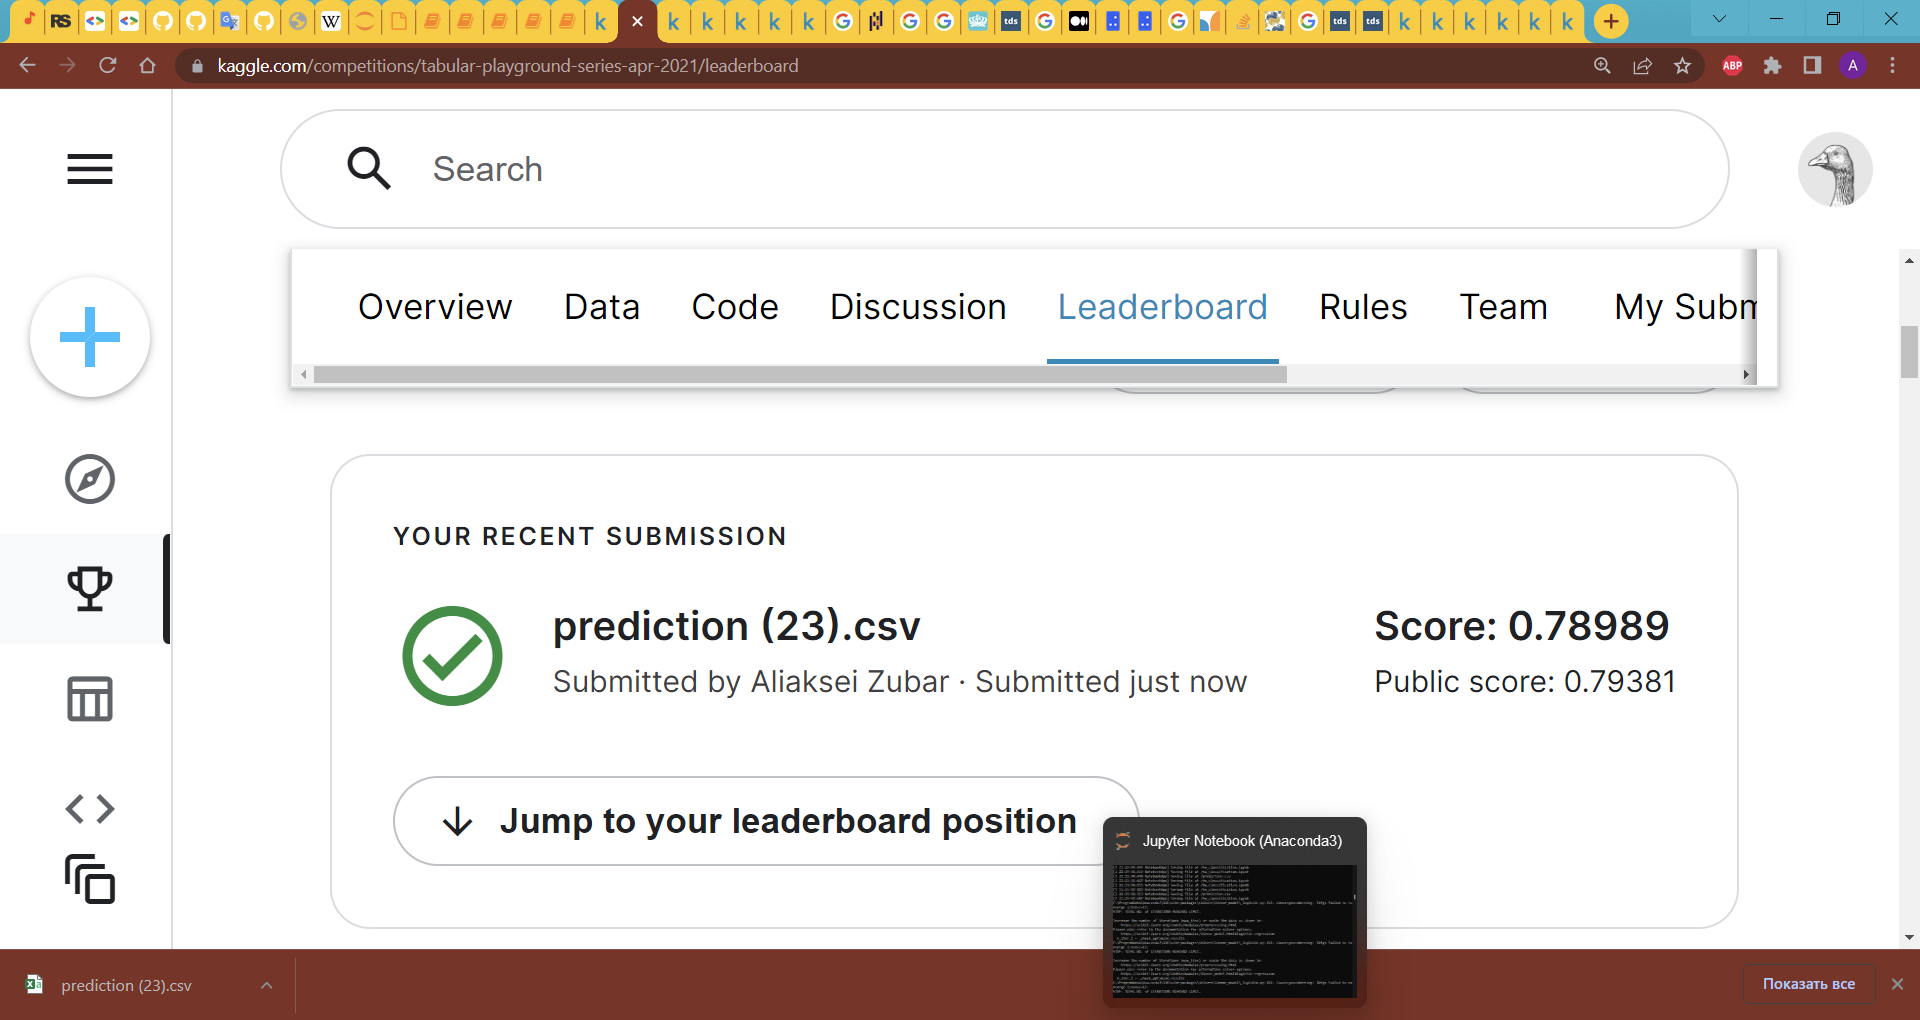